#### This notebook is responsible for YOLOv5 model training using custom dataset

In [10]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np
import wandb
import torch

np.random.seed(42)

In [11]:
TRAIN = True
EPOCHS = 200

# Remove albumentations that yolo applies automatically if installed
! pip3 uninstall albumentations

#### Visualize a few ground truth images

In [12]:
# List of class names
class_names = ["Defective", "Speckled", "Beaded","Clear", "Unknown"]

# Define the colors for each class
colors = [
    (255, 56, 56),   # Red (Class 0)
    (255, 157, 151), # Light Red (Class 1)
    (255, 112, 31),  # Orange (Class 2)
    (255, 178, 29),  # Yellow (Class 3)
    (50, 205, 100),   # Green (Class 4)
]

# Define paths to your dataset
train_images_path = 'data/train/images'
train_labels_path = 'data/train/labels'
valid_images_path = 'data/valid/images'
valid_labels_path = 'data/valid/labels'

In [13]:
# Helper function to plot one bounding box
def plot_one_box(x, img, color=None, label=None, line_thickness=2):
    # Coordinates of the bounding box
    x1, y1, x2, y2 = [int(i) for i in x]
    # Draw rectangle
    cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness=line_thickness)
    # Draw label if provided
    if label:
        font_scale = 0.7
        font_thickness = 1
        t_size = cv2.getTextSize(label, 0, font_scale, font_thickness)[0]
        cv2.putText(img, label, (x1, y1 - 2), 0, font_scale, color, font_thickness, lineType=cv2.LINE_AA)

# Function to visualize the images with ground truth bounding boxes
def visualize_ground_truth(image_dir, label_dir, class_names, num_images=16):
    images = os.listdir(image_dir)

    # Create a 4x4 subplot
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()  # Flatten the 4x4 array to iterate easily

    for idx, image_file in enumerate(images[:num_images]):
        # Load image
        img_path = os.path.join(image_dir, image_file)
        img = cv2.imread(img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

        # Load corresponding label file
        label_file = image_file.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(label_dir, label_file)
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    # Each line in label file: class_idx x_center y_center width height (normalized)
                    class_idx, x_center, y_center, width, height = map(float, line.strip().split())
                    class_idx = int(class_idx)

                    # Convert normalized coordinates to pixel values
                    h, w, _ = img.shape
                    x_center *= w
                    y_center *= h
                    width *= w
                    height *= h
                    x1 = x_center - width / 2
                    y1 = y_center - height / 2
                    x2 = x_center + width / 2
                    y2 = y_center + height / 2

                    # Draw the bounding box with the corresponding color
                    plot_one_box([x1, y1, x2, y2], img, color=colors[class_idx], label=class_names[class_idx])

        # Plot the image in the corresponding subplot
        axes[idx].imshow(img)
        axes[idx].axis('off')  # Turn off axis labels

    # Reduce white space between plots
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.show()

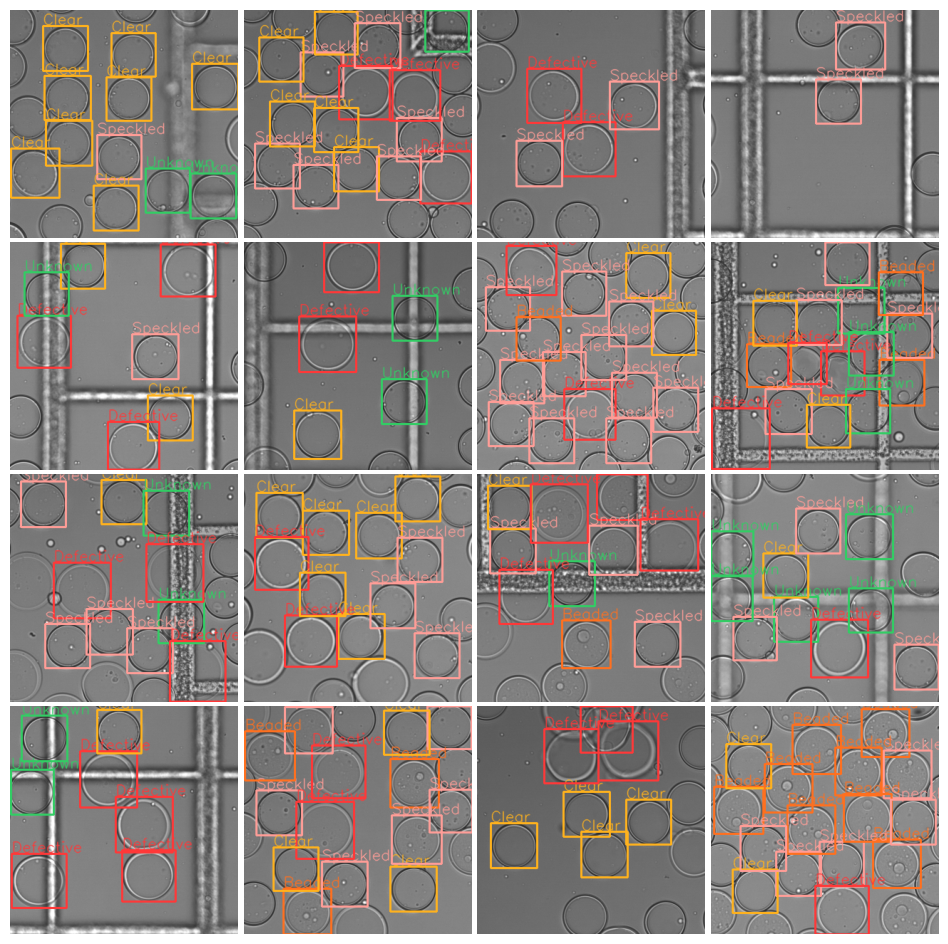

In [14]:
# Visualize 16 training images
visualize_ground_truth(train_images_path, train_labels_path, class_names, num_images=16)

#### Clone YOLOv5 repository and start training

In [15]:
# The original framework can be cloned before its customization
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

In [16]:
# Set the notebook name manually
os.environ["WANDB_NOTEBOOK_NAME"] = "Training/yolo5.ipynb"

# Initialize Weights & Biases (W&B) project with hyperparameter configurations
wandb.init(project="YOLOv5-experiments", name="Run", config={
    "model": "yolov5l",    
    "epochs": EPOCHS,     
    "batch_size": 8,      
    "img_size": 320
})

# Log the configuration for easy reference
config = wandb.config

if TRAIN:
    # Train the YOLOv5 model and log metrics to W&B, using custom hyperparameters
    !python3 yolov5/train.py --data ./data.yaml --cfg {config.model}.yaml --weights yolov5/yolov5l.pt \
    --img {config.img_size} --epochs {config.epochs} --batch-size {config.batch_size} \
    --name Run --project YOLOv5-experiments --entity greta-leonaviciene-dg \
    --hyp custom_hyp.yaml

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: greta-leonaviciene (greta-leonaviciene-dg). Use `wandb login --relogin` to force relogin
train: weights=yolov5/yolov5l.pt, cfg=yolov5l.yaml, data=./data.yaml, hyp=custom_hyp.yaml, epochs=200, batch_size=8, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5/data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=YOLOv5-experiments, name=Run, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=greta-leonaviciene-dg, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github

In [17]:
# Show the last training run results (using file index)
def show_last_valid_results(res_dir):
    # Find the directory with the highest Run number
    highest_run_id = -1
    run_path = None
    for folder_name in os.listdir(res_dir):
        folder_path = os.path.join(res_dir, folder_name)
        if os.path.isdir(folder_path):
            folder_ids = folder_name.split('Run')
            
            # Special case, when there is a single directory
            if "Run" in folder_name and len(folder_ids) == 2 and len(folder_ids[1]) == 0:
                run_id = 0
                if run_id > highest_run_id:
                    highest_run_id = run_id
                    run_path = os.path.join(res_dir, "Run")

            # Typically directories have an index after "Run"
            if "Run" in folder_name and len(folder_ids) == 2 and len(folder_ids[1]) > 0:
                try:
                    run_id = int(folder_ids[1])
                    if run_id > highest_run_id:
                        highest_run_id = run_id
                        run_path = os.path.join(res_dir, f"Run{run_id}")

                except Exception as ex:
                    print("Could not parse folder id: ", str(ex))
    
    # Escape, if folder could not be found
    if highest_run_id == -1:
        print("Run directory could not be found")
        return
    
    validation_pred_images = glob.glob(f"{run_path}/*_pred.jpg")
    print(f"Loading directory: {run_path}\n", "images: ", validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [ ]:
results_dir = "YOLOv5-experiments"
show_last_valid_results(results_dir)